In [1]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.9 MB/s eta 0:00:00


In [2]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.1 MB/s eta 0:00:00


In [3]:
!pip install langgraph openai

In [4]:
from typing import List, Dict, Optional
from langgraph.graph import StateGraph
from langchain_core.runnables.graph import MermaidDrawMethod
import os

class LearningState(Dict):
    student_name: str
    learning_goal: str
    topics: List[str]
    lessons: List[str]
    quizzes: List[Dict[str, str]]
    scores: List[int]
    illustrations: List[str]
    next_steps: Optional[str]


In [45]:
from IPython.display import Markdown,display

In [6]:
os.environ["OPENAI_API_KEY"] = ""

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

PlannerPrompt = ChatPromptTemplate.from_template("""
You are an AI tutor. Given the student's learning goal, generate a structured list of prerequisite two topics they should study.

Student's Learning Goal: {learning_goal}
""")

PlannerAgentStructure = {
    "title": "StudyPlan", # Changed name to remove spaces
    "description": "A structured list of study two topics for a given learning goal.",
    "type": "object",
    "properties": {
        "topics": {
            "type": "array",
            "items": {
                "type": "string"
            },
            "description": "A list of study topics."
        }
    },
    "required": ["topics"]
}
PlannerAgent = PlannerPrompt | ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(PlannerAgentStructure)


In [9]:
res1 = PlannerAgent.invoke({"learning_goal":"i want to learn deep learning"})

In [10]:
res1

{'topics': ['Linear Algebra', 'Probability and Statistics']}

In [8]:
LessonPrompt = ChatPromptTemplate.from_template("""
You are an expert educator. Generate a 2 lines but easy-to-understand lesson for the given topic.

Topic: {topic}
""")

LessonAgentStructure = {
    "title": "LessonContent", # Changed name to remove spaces
    "description": "A detailed and easy-to-understand lesson for a given topic.",
    "type": "object",
    "properties": {
        "lesson": {
            "type": "string",
            "description": "A structured lesson covering the topic in detail."
        }
    },
    "required": ["lesson"]
}
LessonGeneratorAgent = LessonPrompt | ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(LessonAgentStructure)


In [11]:
res2 = LessonGeneratorAgent.invoke({"topic": res1})

In [12]:
res2

{'lesson': 'Linear Algebra: Think of linear algebra as the study of lines and planes, where you learn how to solve systems of equations and understand vector spaces.\n\nProbability and Statistics: Probability helps you predict the likelihood of events, while statistics involves collecting and analyzing data to make informed decisions.'}

In [13]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

QuizPrompt = ChatPromptTemplate.from_template("""
Create a multiple-choice quiz with exactly 5 questions, categorized as follows:
- 2 beginner-level questions
- 2 intermediate-level questions
- 1 expert-level questions

Each question should have four answer choices, with only one correct answer.

Lesson: {lesson}
""")

QuizAgentStructure = {
    "title": "QuizGenerator", # Changed name to remove spaces
    "description": "Generates  a 2 beginner,2 intermediate and 1 expert multiple-choice quiz based on the given lesson.",
    "type": "object",
    "properties": {
        "quizzes": {
            "type": "array",
            "description": "A list of multiple-choice questions.",
            "items": {
                "type": "object",
                "properties": {
                    "question": {
                        "type": "string",
                        "description": "The quiz question."
                    },
                    "options": {
                        "type": "array",
                        "description": "The possible answer choices.",
                        "items": {"type": "string"}
                    },
                    "answer": {
                        "type": "string",
                        "description": "The correct answer to the question."
                    }
                },
                "required": ["question", "options", "answer"]
            }
        }
    },
    "required": ["quizzes"]
}

QuizGeneratorAgent = QuizPrompt | ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(QuizAgentStructure)


In [14]:
res3 = QuizGeneratorAgent.invoke({"lesson": res2})

In [15]:
res3

{'quizzes': [{'question': '1. Beginner: What is the primary focus of linear algebra?',
   'options': ['A) Solving quadratic equations',
    'B) Studying lines and planes',
    'C) Calculating derivatives',
    'D) Analyzing data trends'],
   'answer': 'B) Studying lines and planes'},
  {'question': '2. Beginner: What does probability help you determine?',
   'options': ['A) The exact outcome of an event',
    'B) The likelihood of an event occurring',
    'C) The average of a data set',
    'D) The median of a data set'],
   'answer': 'B) The likelihood of an event occurring'},
  {'question': '3. Intermediate: Which of the following is a key concept in vector spaces?',
   'options': ['A) Eigenvalues',
    'B) Derivatives',
    'C) Mean and median',
    'D) Probability distributions'],
   'answer': 'A) Eigenvalues'},
  {'question': '4. Intermediate: In statistics, what is the purpose of collecting data?',
   'options': ['A) To predict future events',
    'B) To solve algebraic equations

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Prompt to generate structured notes and attach quizzes
NoteGenerationPrompt = ChatPromptTemplate.from_template("""
You are a structured learning assistant. You have a well-defined lesson roadmap and corresponding quizzes for each topic.
Your role is to create well-structured, easy-to-understand notes based on the given lesson and attach the appropriate quiz to each topic.

**Lesson:** {lesson}
**Quiz:** {quiz}

Provide a detailed explanation of the lesson, key points, and any relevant examples.
""")

# Define the expected structured output for notes and quizzes
NoteGenerationAgentStructure = {
    "title": "LessonNoteGenerator",
    "description": "Generates well-structured notes based on the lesson and attaches a quiz to each topic.",
    "type": "object",
    "properties": {
        "structured_notes": {
            "type": "string",
            "description": "A detailed explanation of the lesson, key points, and examples."
        },
        "attached_quiz": {
            "type": "array",
            "items": {
                "type": "string"
            },
            "description": "A list of quiz questions related to the lesson."
        }
    },
    "required": ["structured_notes", "attached_quiz"]
}

# Create the agent using the modified function
NoteGenerationAgent = NoteGenerationPrompt | ChatOpenAI(model="gpt-4o", temperature=0)


In [17]:
res4 = NoteGenerationAgent.invoke({"lesson":res2 ,"quiz":res3})

In [18]:
Markdown(res4.content)

### Lesson Notes: Linear Algebra and Probability & Statistics

#### Linear Algebra

**Overview:**
Linear algebra is a branch of mathematics that focuses on the study of vectors, vector spaces (also known as linear spaces), linear transformations, and systems of linear equations. It is a foundational subject in mathematics with applications in various fields such as engineering, physics, computer science, and economics.

**Key Concepts:**

1. **Vectors and Vector Spaces:**
   - A vector is an object that has both a magnitude and a direction. Vectors can be represented in a coordinate system as an ordered list of numbers.
   - A vector space is a collection of vectors that can be added together and multiplied by scalars (numbers), satisfying certain axioms (e.g., associativity, commutativity).

2. **Lines and Planes:**
   - Linear algebra helps in understanding the geometry of lines and planes in space. A line can be represented as a set of points that satisfy a linear equation, while a plane can be represented by a linear equation in three dimensions.

3. **Systems of Linear Equations:**
   - A system of linear equations is a collection of one or more linear equations involving the same set of variables. The goal is to find the values of the variables that satisfy all the equations simultaneously.
   - Methods to solve these systems include substitution, elimination, and matrix operations such as Gaussian elimination.

4. **Eigenvalues and Eigenvectors:**
   - These are key concepts in vector spaces. An eigenvector of a matrix is a non-zero vector that changes by only a scalar factor when that matrix is applied to it. The corresponding scalar is called an eigenvalue.

**Example:**
Consider the system of equations:
\[ 2x + 3y = 5 \]
\[ 4x + 6y = 10 \]
This system can be solved using Gaussian elimination to find the values of \(x\) and \(y\).

#### Probability and Statistics

**Overview:**
Probability and statistics are branches of mathematics that deal with the analysis of random events and the interpretation of data. Probability provides the theoretical foundation for understanding randomness, while statistics involves the collection, analysis, interpretation, and presentation of data.

**Key Concepts:**

1. **Probability:**
   - Probability is the measure of the likelihood that an event will occur. It is quantified as a number between 0 and 1, where 0 indicates impossibility and 1 indicates certainty.
   - Basic probability concepts include events, sample spaces, and probability distributions.

2. **Statistics:**
   - Statistics involves collecting, analyzing, and interpreting data to make informed decisions. It includes descriptive statistics (summarizing data) and inferential statistics (making predictions or inferences about a population based on a sample).

3. **Data Analysis:**
   - Data analysis involves organizing and examining data to identify patterns or trends. This can include calculating measures of central tendency (mean, median, mode) and measures of variability (range, variance, standard deviation).

**Example:**
If you flip a fair coin, the probability of getting heads is 0.5. If you collect data on the number of heads in 100 coin flips, you can use statistics to analyze the results and make inferences about the fairness of the coin.

### Quiz

1. **Beginner: What is the primary focus of linear algebra?**
   - A) Solving quadratic equations
   - B) Studying lines and planes
   - C) Calculating derivatives
   - D) Analyzing data trends
   - **Answer:** B) Studying lines and planes

2. **Beginner: What does probability help you determine?**
   - A) The exact outcome of an event
   - B) The likelihood of an event occurring
   - C) The average of a data set
   - D) The median of a data set
   - **Answer:** B) The likelihood of an event occurring

3. **Intermediate: Which of the following is a key concept in vector spaces?**
   - A) Eigenvalues
   - B) Derivatives
   - C) Mean and median
   - D) Probability distributions
   - **Answer:** A) Eigenvalues

4. **Intermediate: In statistics, what is the purpose of collecting data?**
   - A) To predict future events
   - B) To solve algebraic equations
   - C) To make informed decisions
   - D) To calculate integrals
   - **Answer:** C) To make informed decisions

5. **Expert: Which method is commonly used to solve systems of linear equations?**
   - A) Integration by parts
   - B) Gaussian elimination
   - C) Bayesian inference
   - D) Monte Carlo simulation
   - **Answer:** B) Gaussian elimination

In [49]:
async def planner_node(state: LearningState):
    print("--- [Planner Agent] ---")
    planner_response = await PlannerAgent.ainvoke({"learning_goal": state['learning_goal']})
    return {"topics": planner_response['topics']}

async def lesson_node(state: LearningState):
    print("--- [Lesson Generator] ---")
    lessons = []
    for topic in state['topics']:
        lesson_response = await LessonGeneratorAgent.ainvoke({"topic": topic})
        lessons.append(lesson_response['lesson'])
    return {"lessons": lessons}

async def quiz_node(state: LearningState):
    print("--- [Quiz Generator] ---")
    quizzes = []
    for lesson in state['lessons']:
        quiz_response = await QuizGeneratorAgent.ainvoke({"lesson": lesson})
        quizzes.append(quiz_response['quizzes'])
    return {"quizzes": quizzes}

async def note_node(state: LearningState):
    print("--- [Note Generator] ---")
    lesson = state["lessons"]
    quiz = state["quizzes"]
    note_response = await NoteGenerationAgent.ainvoke({"lesson": lesson, "quiz": quiz})
    print(display(Markdown(note_response.content)))
    return {"note_response":note_response}


In [50]:
from langgraph.graph import StateGraph, START,END

workflow = StateGraph(LearningState)

workflow.add_node("planner", planner_node)
workflow.add_node("lesson", lesson_node)
workflow.add_node("quiz", quiz_node)
workflow.add_node("note", note_node)


# ✅ Add the missing entry point
workflow.add_edge(START, "planner")

workflow.add_edge("planner", "lesson")
workflow.add_edge("lesson", "quiz")
workflow.add_edge("quiz", "note")
workflow.add_edge("note", END)


app = workflow.compile()


In [31]:
!pip install langchain-experimental # install langchain-experimental

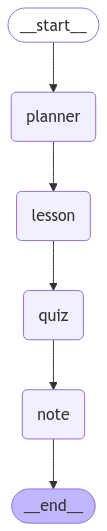

In [22]:
from langchain_core.runnables.graph import MermaidDrawMethod

from IPython.display import Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [51]:
import asyncio

async def run_workflow():
    async for state in app.astream({"learning_goal": "Learn Python basics"}):
        print("\n🔹 Current State:", state)

await run_workflow()


--- [Planner Agent] ---

🔹 Current State: {'planner': {'topics': ['Introduction to Programming Concepts', 'Understanding of Basic Computer Operations']}}
--- [Lesson Generator] ---

🔹 Current State: {'lesson': {'lessons': ['Programming is like giving instructions to a computer to perform tasks, using languages like Python or Java to communicate your ideas clearly and efficiently.', 'Computers process data through input, processing, output, and storage, enabling users to perform tasks efficiently. Mastering basic operations like using a mouse, keyboard, and navigating software is essential for effective computer use.']}}
--- [Quiz Generator] ---

🔹 Current State: {'quiz': {'quizzes': [[{'question': '1. What is programming?', 'options': ['A) A way to paint pictures', 'B) Giving instructions to a computer', 'C) A type of dance', 'D) A cooking technique'], 'answer': 'B) Giving instructions to a computer'}, {'question': '2. Which of the following is a programming language?', 'options': ['A)

### Lesson Notes

#### Topic 1: Understanding Programming

**Definition of Programming:**
- Programming is the process of giving instructions to a computer to perform specific tasks. It involves writing code in a language that the computer can understand and execute.

**Programming Languages:**
- Programming languages like Python and Java are used to communicate ideas clearly and efficiently to a computer. These languages have specific syntax and rules that must be followed to create functional programs.

**Purpose of Programming:**
- The primary purpose of using programming languages is to translate human ideas into a form that computers can process. This allows for the automation of tasks, solving complex problems, and creating applications that can perform a wide range of functions.

**Characteristics of Good Programming Languages:**
- Clarity: The language should be easy to read and understand.
- Efficiency: The language should allow for the creation of programs that run quickly and use resources effectively.
- Flexibility: The language should be adaptable to different types of tasks and problems.
- Avoidance of Ambiguity: A good programming language should have clear and unambiguous syntax to prevent errors.

**Importance of Syntax:**
- Syntax refers to the set of rules that define the structure of a program. Correct syntax is crucial for the program to be understood and executed by the computer.

**Example:**
- Writing a simple program in Python to add two numbers:
  ```python
  def add_numbers(a, b):
      return a + b

  result = add_numbers(5, 3)
  print("The sum is:", result)
  ```
  This program defines a function to add two numbers and then calls the function with specific values, displaying the result.

#### Topic 2: Basic Computer Operations

**Computer Processing:**
- Computers process data through four main stages: input, processing, output, and storage. This cycle enables users to perform tasks efficiently.

**Input Devices:**
- Devices like keyboards and mice are used to enter data into the computer. They are essential for interacting with the computer and providing it with the necessary information to process.

**Output Devices:**
- Devices such as monitors and printers display or produce the results of the computer's processing. They allow users to see and use the information processed by the computer.

**Role of the CPU:**
- The Central Processing Unit (CPU) is the brain of the computer. It processes and executes instructions, performing calculations and managing data flow within the computer.

**Understanding Software:**
- Software refers to the programs and applications that run on a computer. It is distinct from hardware, which comprises the physical components of a computer.

**Importance of Mastering Basic Operations:**
- Mastering basic operations like using a mouse, keyboard, and navigating software is essential for effective computer use. It helps users perform tasks efficiently and effectively, making technology more accessible and useful in everyday life.

**Example:**
- Using a word processor to create a document involves inputting text via a keyboard, processing the text with the software, and displaying the document on a monitor.

### Quizzes

#### Quiz for Topic 1: Understanding Programming

1. What is programming?
   - A) A way to paint pictures
   - B) Giving instructions to a computer
   - C) A type of dance
   - D) A cooking technique
   - **Answer:** B) Giving instructions to a computer

2. Which of the following is a programming language?
   - A) Spanish
   - B) Python
   - C) Algebra
   - D) Geography
   - **Answer:** B) Python

3. What is the primary purpose of using programming languages like Python or Java?
   - A) To create art
   - B) To communicate ideas clearly and efficiently to a computer
   - C) To write novels
   - D) To perform magic tricks
   - **Answer:** B) To communicate ideas clearly and efficiently to a computer

4. Which of the following is NOT a characteristic of a good programming language?
   - A) Clarity
   - B) Efficiency
   - C) Ambiguity
   - D) Flexibility
   - **Answer:** C) Ambiguity

5. In programming, what is the significance of 'syntax'?
   - A) It refers to the speed of the program
   - B) It is the set of rules that defines the combinations of symbols that are considered to be correctly structured programs
   - C) It is the color scheme of the code editor
   - D) It is the name of a popular programming language
   - **Answer:** B) It is the set of rules that defines the combinations of symbols that are considered to be correctly structured programs

#### Quiz for Topic 2: Basic Computer Operations

1. What is the primary function of a computer's input devices?
   - A) To display information
   - B) To store data
   - C) To enter data into the computer
   - D) To process data
   - **Answer:** C) To enter data into the computer

2. Which of the following is an example of an output device?
   - A) Keyboard
   - B) Monitor
   - C) Mouse
   - D) Hard drive
   - **Answer:** B) Monitor

3. What is the role of the CPU in a computer?
   - A) To store data permanently
   - B) To process and execute instructions
   - C) To provide power to the computer
   - D) To display graphics
   - **Answer:** B) To process and execute instructions

4. Which of the following best describes the term 'software'?
   - A) Physical components of a computer
   - B) Programs and applications that run on a computer
   - C) Devices used to input data
   - D) The main circuit board of a computer
   - **Answer:** B) Programs and applications that run on a computer

5. What is the significance of mastering basic computer operations?
   - A) It allows users to build their own computers
   - B) It helps users perform tasks efficiently and effectively
   - C) It enables users to write complex software programs
   - D) It is only necessary for IT professionals
   - **Answer:** B) It helps users perform tasks efficiently and effectively

None

🔹 Current State: {'note': None}


In [52]:
import asyncio

async def run_workflow():
    async for state in app.astream({"learning_goal": "I want to learn about Neural Networks in Deep Learning."}):
        print("\n🔹 Current State:", state)

await run_workflow()


--- [Planner Agent] ---

🔹 Current State: {'planner': {'topics': ['Linear Algebra', 'Probability and Statistics']}}
--- [Lesson Generator] ---

🔹 Current State: {'lesson': {'lessons': ['Linear algebra is the study of vectors, matrices, and linear transformations, which are essential tools for solving systems of linear equations and understanding geometric concepts in higher dimensions.', 'Probability helps us predict the likelihood of events, while statistics involves collecting and analyzing data to understand patterns and trends.']}}
--- [Quiz Generator] ---

🔹 Current State: {'quiz': {'quizzes': [[{'question': 'What is a vector in linear algebra?', 'options': ['A) A single number', 'B) A matrix with one row or column', 'C) A geometric shape', 'D) A type of equation'], 'answer': 'B) A matrix with one row or column'}, {'question': 'Which of the following is a common use of matrices?', 'options': ['A) Solving quadratic equations', 'B) Representing systems of linear equations', 'C) Calc

### Lesson Notes

#### Topic 1: Linear Algebra

**Overview:**
Linear algebra is a branch of mathematics that focuses on vectors, matrices, and linear transformations. These concepts are fundamental for solving systems of linear equations and understanding geometric concepts in higher dimensions.

**Key Concepts:**

1. **Vectors:**
   - A vector is an entity that has both magnitude and direction. In linear algebra, vectors are often represented as matrices with one row or one column.
   - Example: A vector in 2D space can be represented as \([x, y]\).

2. **Matrices:**
   - A matrix is a rectangular array of numbers arranged in rows and columns. Matrices are used to represent and solve systems of linear equations.
   - Example: A 2x2 matrix looks like \(\begin{bmatrix} a & b \\ c & d \end{bmatrix}\).

3. **Determinant:**
   - The determinant is a scalar value that can be computed from the elements of a square matrix. It provides important properties of the matrix, such as whether it is invertible.
   - Example: The determinant of a 2x2 matrix \(\begin{bmatrix} a & b \\ c & d \end{bmatrix}\) is calculated as \(ad - bc\).

4. **Eigenvectors and Eigenvalues:**
   - Eigenvectors are vectors that do not change direction under a linear transformation, although they may be scaled by a factor known as the eigenvalue.
   - Example: If \(A\) is a matrix and \(v\) is an eigenvector, then \(Av = \lambda v\), where \(\lambda\) is the eigenvalue.

5. **Rank:**
   - The rank of a matrix is the maximum number of linearly independent row vectors in the matrix. It indicates the dimension of the vector space spanned by its rows or columns.

**Applications:**
- Linear algebra is widely used in computer graphics, engineering, physics, machine learning, and more.

**Quiz for Linear Algebra:**
1. What is a vector in linear algebra?
2. Which of the following is a common use of matrices?
3. What is the determinant of a 2x2 matrix \(\begin{bmatrix} a & b \\ c & d \end{bmatrix}\)?
4. Which of the following statements is true about eigenvectors?
5. In linear algebra, what is the rank of a matrix?

---

#### Topic 2: Probability and Statistics

**Overview:**
Probability and statistics are mathematical disciplines that deal with the analysis of random events and data. Probability helps predict the likelihood of events, while statistics involves collecting and analyzing data to understand patterns and trends.

**Key Concepts:**

1. **Probability:**
   - Probability is a measure of the likelihood that an event will occur. It ranges from 0 (impossible event) to 1 (certain event).
   - Example: The probability of flipping a fair coin and it landing on heads is 0.5.

2. **Statistical Measures:**
   - Statistical measures are used to summarize and describe data. Common measures include mean, median, mode, variance, and standard deviation.
   - Example: The mean is the average of a set of numbers.

3. **Probability in Practice:**
   - Probability is used to calculate the likelihood of various outcomes in different scenarios, such as drawing a card from a deck or rolling a die.
   - Example: The probability of drawing a red ball from a bag containing 3 red balls and 2 blue balls is 0.6.

4. **Data Analysis:**
   - Statistics involves collecting, analyzing, interpreting, and presenting data. It helps in making informed decisions based on data trends.
   - Example: If 60% of survey respondents prefer tea over coffee, and 200 people were surveyed, 120 people preferred tea.

5. **Advanced Probability:**
   - More complex probability problems involve combinations and permutations, such as calculating the probability of drawing an Ace or a King from a deck of cards.

**Quiz for Probability and Statistics:**
1. Beginner: What is the probability of flipping a fair coin and it landing on heads?
2. Beginner: Which of the following is an example of a statistical measure?
3. Intermediate: If a bag contains 3 red balls and 2 blue balls, what is the probability of drawing a red ball?
4. Intermediate: In a survey, 60% of respondents prefer tea over coffee. If 200 people were surveyed, how many preferred tea?
5. Expert: A deck of cards has 52 cards. What is the probability of drawing an Ace or a King from a shuffled deck?

None

🔹 Current State: {'note': None}
